<a href="https://colab.research.google.com/github/j15975383/DSMA/blob/main/DSMAv2_Goemotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!git clone https://github.com/google-research/google-research.git
!git clone https://github.com/monologg/GoEmotions-pytorch.git

#https://github.com/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb
#https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/
#https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

fatal: destination path 'GoEmotions-pytorch' already exists and is not an empty directory.


In [ ]:
!pip install transformers #--force-reinstall

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import AutoModel, BertTokenizer

# specify GPU
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import pandas as pd

train = pd.read_csv("/content/GoEmotions-pytorch/data/group/train.tsv",sep = '\t', header = None)
labels = pd.read_csv("/content/GoEmotions-pytorch/data/group/labels.txt")
test = pd.read_csv("/content/GoEmotions-pytorch/data/group/test.tsv",sep = '\t',header = None)

In [ ]:
print(train.info())
print(train.head())
train[1].value_counts(normalize = True)
#Here we found out that there are cases where there are multilabels

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       43410 non-null  object
 1   1       43410 non-null  object
 2   2       43410 non-null  object
dtypes: object(3)
memory usage: 1017.5+ KB
None
                                                   0  1        2
0  My favourite food is anything I didn't have to...  2  eebbqej
1  Now if he does off himself, everyone will thin...  2  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING  1  eezlygj
3                        To make her feel threatened  1  ed7ypvh
4                             Dirty Southern Wankers  1  ed0bdzj


3        0.350518
2        0.295393
1        0.187353
0        0.088874
1,3      0.018083
0,3      0.017853
2,3      0.013660
1,2      0.011126
0,1      0.009145
0,2      0.006957
0,1,3    0.000622
1,2,3    0.000230
0,1,2    0.000092
0,2,3    0.000092
Name: 1, dtype: float64

In [ ]:
#And so we remove the multilabels for simplistics sake
filter = train[1].str.len()>1
train_single = train[~filter]
filter1 = train_single[1]=='1'
filter2 = train_single[1]=='3'
train_single = train_single[filter1|filter2]
filter = train_single[1]=='1'
train_single[1][filter] = 0
filter = train_single[1]=='3'
train_single[1][filter] = 1

train_single[1].value_counts(normalize = True)

1    0.651677
0    0.348323
Name: 1, dtype: float64

In [ ]:
train_single.head

<bound method NDFrame.head of                                                        0  1        2
2                         WHY THE FUCK IS BAYLESS ISOING  0  eezlygj
3                            To make her feel threatened  0  ed7ypvh
4                                 Dirty Southern Wankers  0  ed0bdzj
6      Yes I heard abt the f bombs! That has to be wh...  1  ee3b6wu
7      We need more boards and to create a bit more s...  1  ef4qmod
...                                                  ... ..      ...
43400  [NAME] was half-blood but it wasn't a smart id...  0  eerlirr
43405  Added you mate well I’ve just got the bow and ...  1  edsb738
43407  What are you talking about? Anything bad that ...  0  efgbhks
43408            More like a baptism, with sexy results!  1  ed1naf8
43409                                    Enjoy the ride!  1  eecwmbq

[23349 rows x 3 columns]>

In [ ]:
#We also do this for the test set
filter = test[1].str.len()>1
test_single = test[~filter]
filter1 = test_single[1]=='1'
filter2 = test_single[1]=='3'
test_single = test_single[filter1|filter2]
filter = test_single[1]=='1'
test_single[1][filter] = 0
filter = test_single[1]=='3'
test_single[1][filter] = 1
test_single[1].value_counts(normalize = True)

1    0.635186
0    0.364814
Name: 1, dtype: float64

In [ ]:
#torch.tensor requires the labels to be ints instead of strs
#we hereby change the datatype of the labels
train_single[1] = train_single[1].apply(lambda x: int(x))
test_single[1] = test_single[1].apply(lambda x: int(x))
print(train_single.info())
print(test_single.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23349 entries, 2 to 43409
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       23349 non-null  object
 1   1       23349 non-null  int64 
 2   2       23349 non-null  object
dtypes: int64(1), object(2)
memory usage: 729.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2933 entries, 0 to 5425
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2933 non-null   object
 1   1       2933 non-null   int64 
 2   2       2933 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.7+ KB
None


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
bert = AutoModel.from_pretrained("bert-base-cased",return_dict = False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#just to test things out
text = ["I hate you Anakin","You were like a brother to me"]
tokens = tokenizer.batch_encode_plus(text,padding = True, return_token_type_ids=False)
print(tokens)
tokens['input_ids']
tokenizer.batch_decode(tokens['input_ids'])
#or we can use
#tokenizer.decode(tokens['input_ids'][0])
#to find the decoded first sentence

{'input_ids': [[101, 146, 4819, 1128, 9954, 4314, 102, 0, 0], [101, 1192, 1127, 1176, 170, 1711, 1106, 1143, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}


['[CLS] I hate you Anakin [SEP] [PAD] [PAD]',
 '[CLS] You were like a brother to me [SEP]']

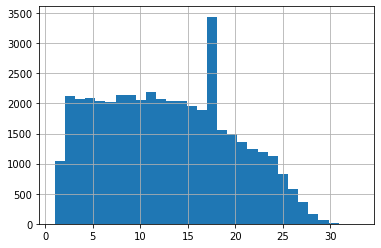

In [ ]:
seq_len = [len(i.split()) for i in train[0]]

pd.Series(seq_len).hist(bins = 30)
#since most of them fall well within 30, we'll make the max_seq_length =30
max_seq_len = 30

In [ ]:
#split test dataset into validation and test
val_text, test_text, val_labels, test_labels = train_test_split(test_single[0], test_single[1], 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=test_single[1])

In [ ]:
tokens_train = tokenizer.batch_encode_plus(
    train_single[0].values.tolist(),
    max_length = max_seq_len,
    padding = True,
    truncation=True,
    return_token_type_ids=False
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding = True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding = True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_single[1].values.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
train_labels = train_single[1].values
train_labels = pd.Series(train_labels)
#compute the class weights

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )
#class_weights = dict(zip(np.unique(train_labels), class_weights)),
print(class_weights)

[1.43544817 0.76725158]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 15

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 15
  Batch    50  of    730.
  Batch   100  of    730.
  Batch   150  of    730.
  Batch   200  of    730.
  Batch   250  of    730.
  Batch   300  of    730.
  Batch   350  of    730.
  Batch   400  of    730.
  Batch   450  of    730.
  Batch   500  of    730.
  Batch   550  of    730.
  Batch   600  of    730.
  Batch   650  of    730.
  Batch   700  of    730.

Evaluating...

Training Loss: 0.613
Validation Loss: 0.500

 Epoch 2 / 15
  Batch    50  of    730.
  Batch   100  of    730.
  Batch   150  of    730.
  Batch   200  of    730.
  Batch   250  of    730.
  Batch   300  of    730.
  Batch   350  of    730.
  Batch   400  of    730.
  Batch   450  of    730.
  Batch   500  of    730.
  Batch   550  of    730.
  Batch   600  of    730.
  Batch   650  of    730.
  Batch   700  of    730.

Evaluating...

Training Loss: 0.553
Validation Loss: 0.462

 Epoch 3 / 15
  Batch    50  of    730.
  Batch   100  of    730.
  Batch   150  of    730.
  Batch   200  of    730.
  B

In [ ]:
torch.save(model, "/content/model.pt")

In [ ]:
path = '/content/saved_weights.pt'
model.load_state_dict(torch.load(path))

In [ ]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))